In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from churn_opt.data import load_telco_csv
from churn_opt.features import add_features
from churn_opt.models import build_pipeline
from churn_opt.scenarios import SCENARIOS
from churn_opt.profit import (
    compute_expected_profit_per_customer,
    profit_from_targeting,
    select_score_threshold_by_profit,
)

sns.set_theme()
plt.rcParams["figure.figsize"] = (9, 5)


In [2]:
df = load_telco_csv("../data/raw/Telco-Customer-Churn.csv")
df = add_features(df)

if "TotalCharges" in df.columns:
    df = df.drop(columns=["TotalCharges"])

train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Churn"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.25, stratify=train_df["Churn"], random_state=42)

X_train = train_df.drop(columns=["Churn"])
y_train = train_df["Churn"].values
X_val = val_df.drop(columns=["Churn"])
y_val = val_df["Churn"].values
X_test = test_df.drop(columns=["Churn"])
y_test = test_df["Churn"].values

mc_val = X_val["MonthlyCharges"].to_numpy()
mc_test = X_test["MonthlyCharges"].to_numpy()

df.shape, train_df.shape, val_df.shape, test_df.shape


((7043, 23), (4225, 23), (1409, 23), (1409, 23))

In [3]:
pipe_lr = build_pipeline(train_df, model_type="lr", random_state=42)
pipe_hgb = build_pipeline(train_df, model_type="hgb", random_state=42)

pipe_lr.fit(X_train, y_train)
pipe_hgb.fit(X_train, y_train)

p_val_lr = pipe_lr.predict_proba(X_val)[:, 1]
p_test_lr = pipe_lr.predict_proba(X_test)[:, 1]

p_val_hgb = pipe_hgb.predict_proba(X_val)[:, 1]
p_test_hgb = pipe_hgb.predict_proba(X_test)[:, 1]


In [4]:
def profit_curve_for_scenario(p_val, p_test, scen, ks):
    """
    Returns a DataFrame with k, profit_test, plus baselines and threshold policy profit.
    """
    # profit score
    score_val = compute_expected_profit_per_customer(p_val, mc_val, scen)
    score_test = compute_expected_profit_per_customer(p_test, mc_test, scen)

    # baselines
    call_none = profit_from_targeting(y_test, np.zeros_like(y_test, dtype=bool), mc_test, scen)
    call_all  = profit_from_targeting(y_test, np.ones_like(y_test, dtype=bool),  mc_test, scen)

    # threshold chosen on VAL
    best_s, _ = select_score_threshold_by_profit(score_val, y_val, mc_val, scen)
    targeted_test_s = (score_test >= best_s)
    profit_threshold = profit_from_targeting(y_test, targeted_test_s, mc_test, scen)
    target_rate_threshold = targeted_test_s.mean()

    # top-k curve on TEST (score-based)
    order = np.argsort(-score_test)
    n = len(score_test)

    rows = []
    for k in ks:
        m = max(1, int(round(n * k)))
        targeted = np.zeros(n, dtype=bool)
        targeted[order[:m]] = True
        prof = profit_from_targeting(y_test, targeted, mc_test, scen)
        rows.append({"k": float(k), "profit": float(prof), "target_rate": float(targeted.mean())})

    out = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    out["call_none_profit"] = call_none
    out["call_all_profit"] = call_all
    out["threshold_profit"] = profit_threshold
    out["threshold_target_rate"] = float(target_rate_threshold)
    out["threshold_score"] = float(best_s)
    return out


In [5]:
ks = np.linspace(0.01, 1.00, 100)

curves = {}
for scen_key, scen in SCENARIOS.items():
    curves[("LR", scen_key)]  = profit_curve_for_scenario(p_val_lr,  p_test_lr,  scen, ks)
    curves[("HGB", scen_key)] = profit_curve_for_scenario(p_val_hgb, p_test_hgb, scen, ks)

list(curves.keys())


[('LR', 'worst'),
 ('HGB', 'worst'),
 ('LR', 'base'),
 ('HGB', 'base'),
 ('LR', 'best'),
 ('HGB', 'best')]

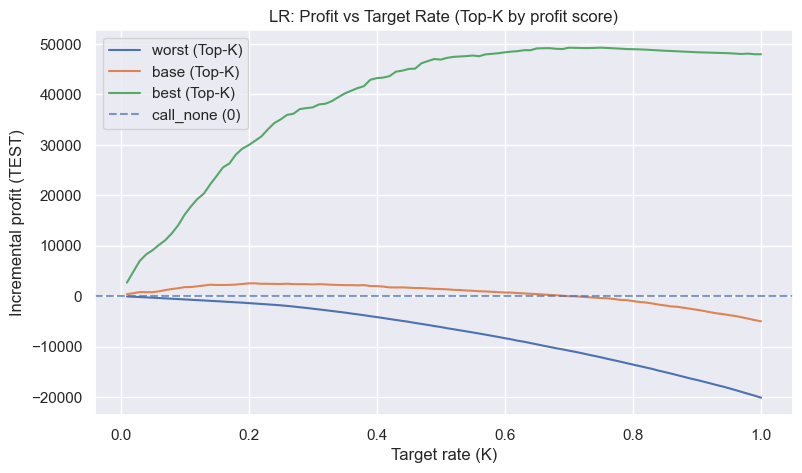

In [6]:
for scen_key in ["worst", "base", "best"]:
    dfc = curves[("LR", scen_key)]
    plt.plot(dfc["k"], dfc["profit"], label=f"{scen_key} (Top-K)")

plt.axhline(curves[("LR","base")]["call_none_profit"].iloc[0], linestyle="--", alpha=0.7, label="call_none (0)")
plt.xlabel("Target rate (K)")
plt.ylabel("Incremental profit (TEST)")
plt.title("LR: Profit vs Target Rate (Top-K by profit score)")
plt.legend()
plt.show()


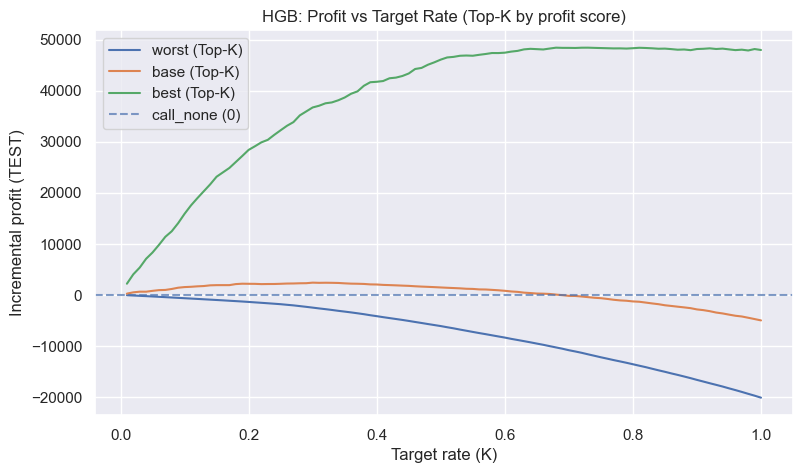

In [7]:
for scen_key in ["worst", "base", "best"]:
    dfc = curves[("HGB", scen_key)]
    plt.plot(dfc["k"], dfc["profit"], label=f"{scen_key} (Top-K)")

plt.axhline(curves[("HGB","base")]["call_none_profit"].iloc[0], linestyle="--", alpha=0.7, label="call_none (0)")
plt.xlabel("Target rate (K)")
plt.ylabel("Incremental profit (TEST)")
plt.title("HGB: Profit vs Target Rate (Top-K by profit score)")
plt.legend()
plt.show()


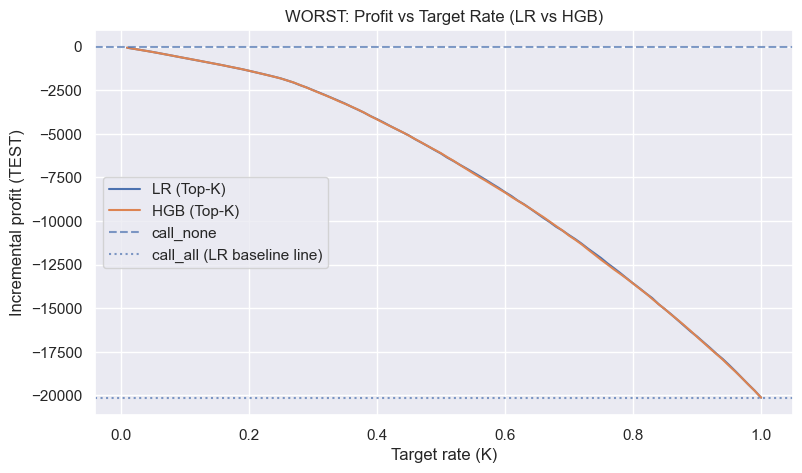

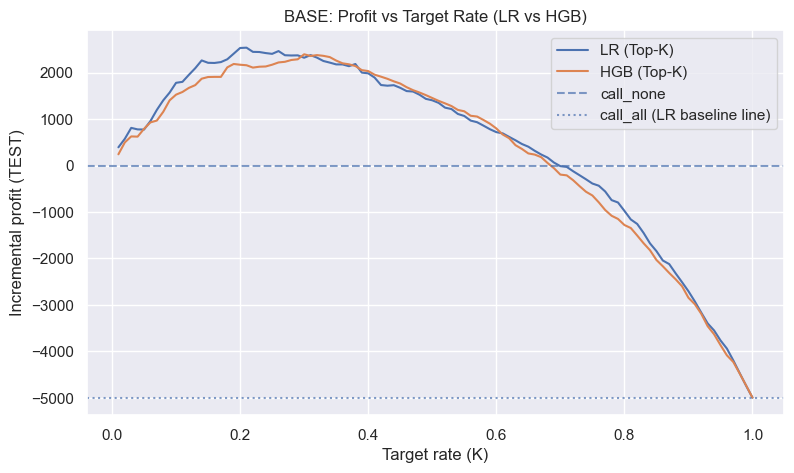

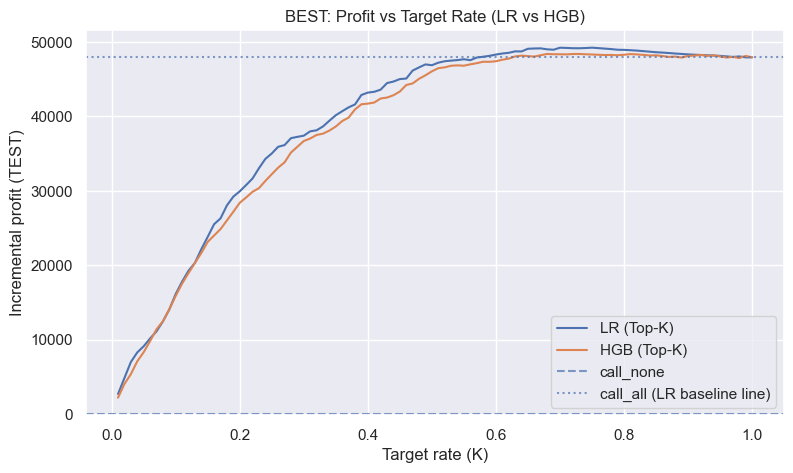

In [8]:
for scen_key in ["worst", "base", "best"]:
    df_lr = curves[("LR", scen_key)]
    df_hg = curves[("HGB", scen_key)]

    plt.plot(df_lr["k"], df_lr["profit"], label="LR (Top-K)")
    plt.plot(df_hg["k"], df_hg["profit"], label="HGB (Top-K)")

    # baselines
    plt.axhline(df_lr["call_none_profit"].iloc[0], linestyle="--", alpha=0.7, label="call_none")
    plt.axhline(df_lr["call_all_profit"].iloc[0], linestyle=":",  alpha=0.7, label="call_all (LR baseline line)")

    plt.xlabel("Target rate (K)")
    plt.ylabel("Incremental profit (TEST)")
    plt.title(f"{scen_key.upper()}: Profit vs Target Rate (LR vs HGB)")
    plt.legend()
    plt.show()


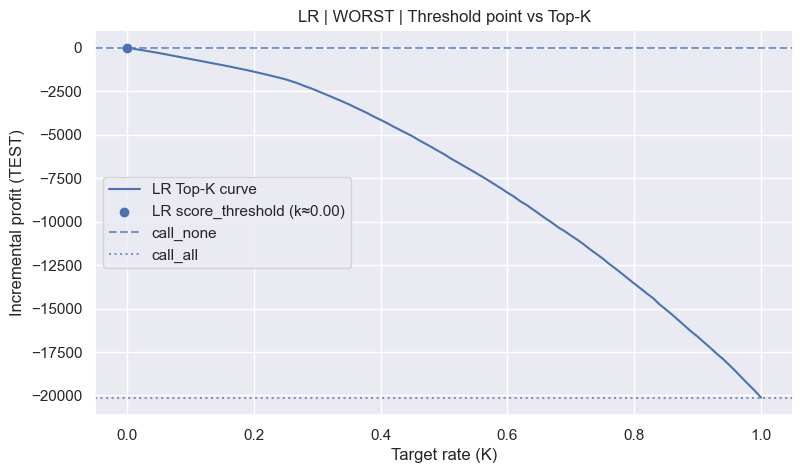

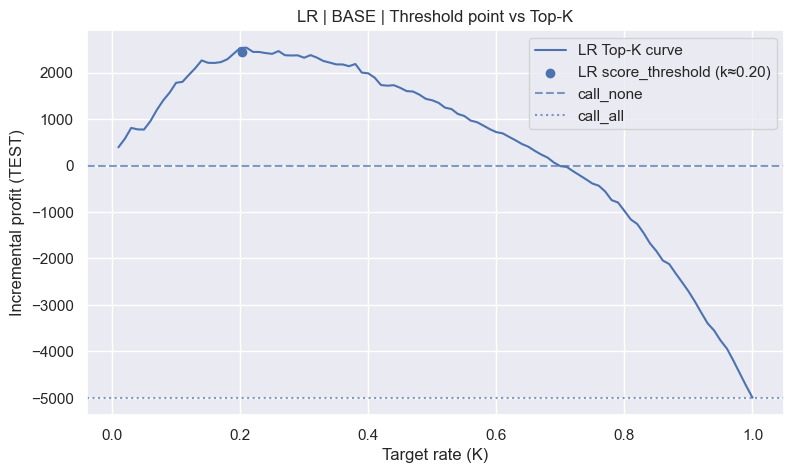

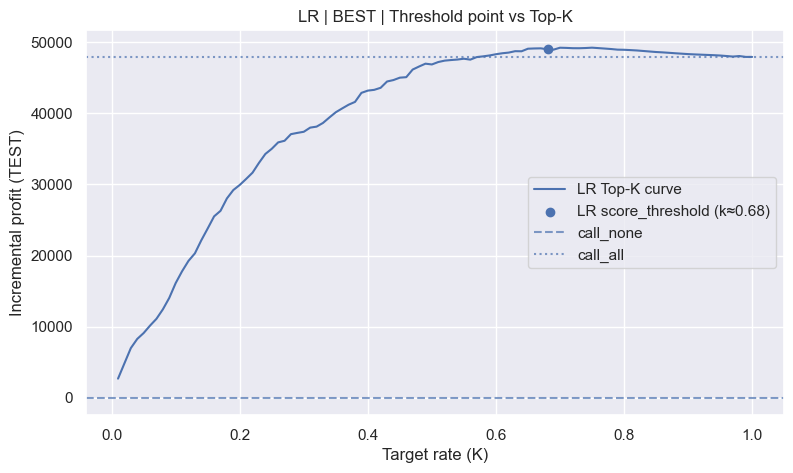

In [9]:
for scen_key in ["worst", "base", "best"]:
    df_lr = curves[("LR", scen_key)]
    k_thr = df_lr["threshold_target_rate"].iloc[0]
    p_thr = df_lr["threshold_profit"].iloc[0]

    plt.plot(df_lr["k"], df_lr["profit"], label="LR Top-K curve")
    plt.scatter([k_thr], [p_thr], label=f"LR score_threshold (k≈{k_thr:.2f})")

    plt.axhline(df_lr["call_none_profit"].iloc[0], linestyle="--", alpha=0.7, label="call_none")
    plt.axhline(df_lr["call_all_profit"].iloc[0], linestyle=":",  alpha=0.7, label="call_all")

    plt.xlabel("Target rate (K)")
    plt.ylabel("Incremental profit (TEST)")
    plt.title(f"LR | {scen_key.upper()} | Threshold point vs Top-K")
    plt.legend()
    plt.show()


In [10]:
rows = []
for model in ["LR", "HGB"]:
    for scen_key in ["worst", "base", "best"]:
        dfc = curves[(model, scen_key)].copy()
        best_row = dfc.loc[dfc["profit"].idxmax()]
        rows.append({
            "model": model,
            "scenario": scen_key,
            "best_k_test": float(best_row["k"]),
            "best_profit_test": float(best_row["profit"]),
            "threshold_profit": float(dfc["threshold_profit"].iloc[0]),
            "threshold_k_test": float(dfc["threshold_target_rate"].iloc[0]),
            "call_all_profit": float(dfc["call_all_profit"].iloc[0]),
            "call_none_profit": float(dfc["call_none_profit"].iloc[0]),
        })

summary = pd.DataFrame(rows).sort_values(["scenario", "model"])
summary


,model,scenario,best_k_test,best_profit_test,threshold_profit,threshold_k_test,call_all_profit,call_none_profit
4,HGB,base,0.30,2395.6900,2183.102,0.250532,-4997.088,0.0
1,LR,base,0.21,2537.9240,2445.306,0.203691,-4997.088,0.0
5,HGB,best,0.68,48404.0640,48266.676,0.662172,47948.040,0.0
2,LR,best,0.75,49248.4860,49018.944,0.681334,47948.040,0.0
3,HGB,worst,0.01,-59.5725,0.000,0.000000,-20125.959,0.0
0,LR,worst,0.01,-62.8475,0.000,0.000000,-20125.959,0.0


In the worst-case scenario, the economically optimal decision is often not to run any retention campaign at all (call_none), since intervention costs exceed the expected recovered value.

In the base and best scenarios, the optimal targeting rate K is typically moderate; blindly targeting everyone (call_all) can destroy value due to unnecessary discount and contact costs.

The score-threshold policy is more flexible than a fixed Top-K strategy and often achieves higher profit, because it adapts the targeting rate to the economic conditions of the scenario.

Although HistGradientBoosting is a more complex model, Logistic Regression generalizes better for decision-making due to superior probability calibration and stability.
